In [1]:
# Google Colab and Google Drive connection
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import string
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import re

# ---------------------
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
stop=set(stopwords.words('english'))

# ---------------------

from collections import defaultdict
from collections import  Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# ---------------------
import keras
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
tweet = pd.read_csv('/content/drive/MyDrive/bds/nlp-disaster-tweets/train.csv')
test = pd.read_csv('/content/drive/MyDrive/bds/nlp-disaster-tweets/test.csv')

In [4]:
def create_corpus(target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [5]:
def create_corpus_df(tweet, target):
    corpus=[]
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [6]:
df = pd.concat([tweet,test])
df.shape

(10876, 5)

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
df['text'] = df['text'].apply(lambda x: clean_text(x))
df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [9]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [10]:
tweet_1 = tweet.text.values
test_1 = test.text.values
sentiments = tweet.target.values

In [11]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(tweet_1)
vocab_length = len(word_tokenizer.word_index) + 1

In [12]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [13]:
def metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [14]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A ',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [15]:
longest_train = max(tweet_1, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(tweet_1), length_long_sentence, padding='post')
test_sentences = pad_sequences(
    embed(test_1), 
    length_long_sentence,
    padding='post'
)

In [16]:
embeddings_dictionary = dict()
embedding_dim = 100
glove_file = open('/content/drive/MyDrive/bds/glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [17]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sentences, 
    sentiments, 
    test_size=0.25
)

In [29]:
def model_1():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [30]:
model = model_1()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(
    X_train, 
    y_train, 
    epochs = 7,
    batch_size = 32,
    validation_data = [X_test, y_test],
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/7
179/179 [==============================] - ETA: 0s - loss: 0.6975 - accuracy: 0.6723
Epoch 00001: val_loss improved from inf to 0.58224, saving model to model.h5
179/179 [==============================] - 47s 231ms/step - loss: 0.6975 - accuracy: 0.6723 - val_loss: 0.5822 - val_accuracy: 0.8036 - lr: 0.0010
Epoch 2/7
179/179 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.7613
Epoch 00002: val_loss improved from 0.58224 to 0.50033, saving model to model.h5
179/179 [==============================] - 41s 228ms/step - loss: 0.5186 - accuracy: 0.7613 - val_loss: 0.5003 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 3/7
179/179 [==============================] - ETA: 0s - loss: 0.4534 - accuracy: 0.8068
Epoch 00003: val_loss improved from 0.50033 to 0.43192, saving model to model.h5
179/179 [==============================] - 40s 223ms/step - loss: 0.4534 - accuracy: 0.8068 - val_loss: 0.4319 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 4/7
179/179 [================

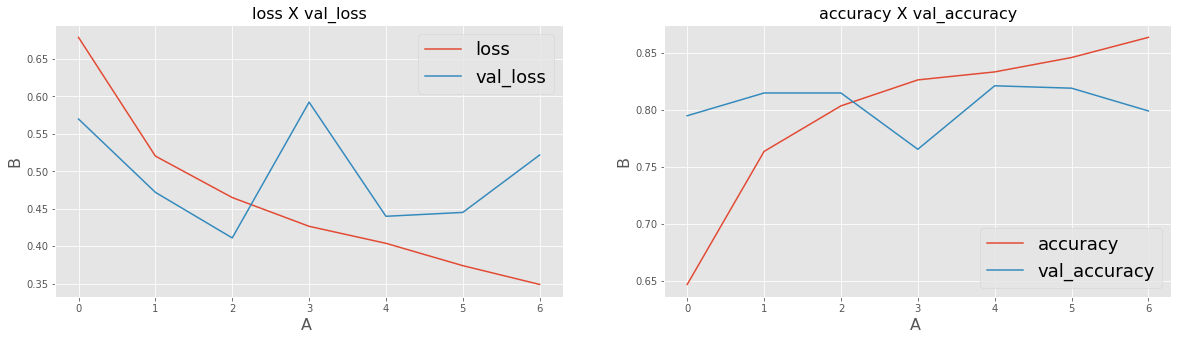

In [21]:
plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Loss:', loss)
print('Accuracy:', accuracy)

60/60 [==============================] - 2s 34ms/step - loss: 0.5219 - accuracy: 0.7988
Loss: 0.5218583941459656
Accuracy: 0.7988445162773132
